In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as clrs

from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.models import load_model

#for data processing
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

import pickle

import time

Using TensorFlow backend.


In [4]:
train_matrices_path = "/home/oala/Documents/QUEAI/luis_messy/quick_and_dirty/conv_test_run_det/matrices-train/epoch100.pickle"
test_matrices_path = "/home/oala/Documents/QUEAI/luis_messy/quick_and_dirty/conv_test_run_det/matrices-test/epoch100.pickle"

In [10]:
def make_plot_prob(matrices_path, data_split, N):
    with open(matrices_path, 'rb') as handle:
        matrices = pickle.load(handle)
    imgs = matrices['imgs']
    refs = matrices['refs']
    mean_out = matrices['mean_out']
    var_out = matrices['var_out']
    
    for i in range(N):
        print('var')
        print('max: ', np.amax(var_out[i]))
        print('min: ', np.amin(var_out[i]))
        print('sum: ', np.sum(var_out[i]))
        
        print('mean')
        print('max: ', np.amax(mean_out[i]))
        print('min: ', np.amin(mean_out[i]))
        print('sum: ', np.sum(mean_out[i]))
        
        print('log var')
        print('max: ', np.amax(np.log(var_out[i])))
        print('min: ', np.amin(np.log(var_out[i])))
        print('sum: ', np.sum(np.log(var_out[i])))
        mean_max = np.amax(mean_out[i])
        mean_min = np.amin(mean_out[i])
        
        #first image level
        r, c = 1, 10
        print('Image '+str(i)+' from '+data_split+' data')
        fig, axs = plt.subplots(r, c, figsize=(25,25))
        
        im1 = axs[0].imshow(np.squeeze(imgs[i, :,:]))
        axs[0].set_title('input image')
        axs[0].axis('off')
        
        im2 = axs[1].imshow(np.squeeze(refs[i, :,:]))
        axs[1].set_title('ref image')
        axs[1].axis('off')

        im3 = axs[2].imshow(np.squeeze(mean_out[i, :,:]), vmin=0, vmax=1)
        axs[2].set_title('mean out')
        axs[2].axis('off')
        
        im4 = axs[3].imshow(np.log(np.squeeze(1e-45+(refs[i, :,:]-mean_out[i, :,:])**2)))#, vmin=0, vmax=1)
        axs[3].set_title('log((f(x)-x)**2)')
        axs[3].axis('off')
        
        im5 = axs[4].imshow(np.log(np.squeeze(var_out[i, :,:]+1e-45)))#,vmin=0, vmax=1)
        axs[4].set_title('log(var out)')
        axs[4].axis('off')
        
        im6 = axs[5].imshow(np.squeeze((refs[i, :,:]-mean_out[i, :,:])**2))#, vmin=0, vmax=1)
        axs[5].set_title('f(x)-x)**2')
        axs[5].axis('off')
        
        im7 = axs[6].imshow(np.squeeze(var_out[i, :,:]))#,vmin=0, vmax=1)
        axs[6].set_title('var out')
        axs[6].axis('off')
        
        im8 = axs[7].imshow(np.squeeze(np.abs(refs[i, :,:]-mean_out[i, :,:])))#, vmin=0, vmax=1))
        axs[7].set_title('abs(f(x)-x)')
        axs[7].axis('off')
        
        im9 = axs[8].imshow(np.squeeze(np.abs(mean_out[i, :,:]-np.log(var_out[i, :,:]+1e-45))))#, vmin=0, vmax=1))
        axs[8].set_title('abs(mean - log(var))')
        axs[8].axis('off')
        
        im10 = axs[9].imshow(np.squeeze(np.log(var_out[i, :,:]+1e-45)+np.log(np.sqrt(2*np.pi*np.exp(1)))))#, vmin=0, vmax=1))
        axs[9].set_title('diff entropy')
        axs[9].axis('off')
        
        #fig.savefig("images-test/%d.png" % epoch)
        #fig.colorbar(im5, ax=axs, fraction=.01)
        
        plt.show()
        plt.close()

def make_plot_det(matrices_path, data_split, N):
    with open(matrices_path, 'rb') as handle:
        matrices = pickle.load(handle)
    imgs = matrices['imgs']
    refs = matrices['refs']
    imgs_out = matrices['imgs_out']
    
    T = refs.shape[1]
    
    for i in range(6):
        plt.figure(figsize = (20,10))
        plt.plot(np.arange(T), imgs_out[i,:,0], label = 'Prediction', color = 'blue', linestyle='--', alpha=0.5)
        plt.plot(np.arange(T), imgs[i,:,0], label = 'Input', color = 'black', linestyle=':', alpha=0.5)
        plt.plot(np.arange(T), refs[i,:,0], label = 'Target', color = 'green')
        
        error = np.abs(refs[i,:,0] - imgs_out[i,:,0])
        
        plt.plot(np.arange(T), error, label = 'Absolute error', color = 'red', lw= 1.)
        
        plt.legend()
        plt.show()
        plt.close()

def SNR(rec, oracle):
    sumP = np.sum(oracle)
    sumI = np.sum(rec)
    sumIP = np.sum(oracle*rec)
    sumI2 = np.sum(rec**2)
    A = np.array([[sumI2, sumI],[sumI, oracle.size]])
    b = np.array([[sumIP],[sumP]])
    c,_,_,_ = np.linalg.lstsq(A,b)
    #print(c)
    rec = c[0]*rec + c[1]
    err = np.sum((oracle - rec)**2)
    SNR = 10*np.log10(np.sum(oracle**2)/err)

    return SNR

def avg_SNR(REC, ORACLE):
    N = REC.shape[0]
    total_SNR = 0
    for i in range(N):
        total_SNR += SNR(REC[i], ORACLE[i])

    return total_SNR/N

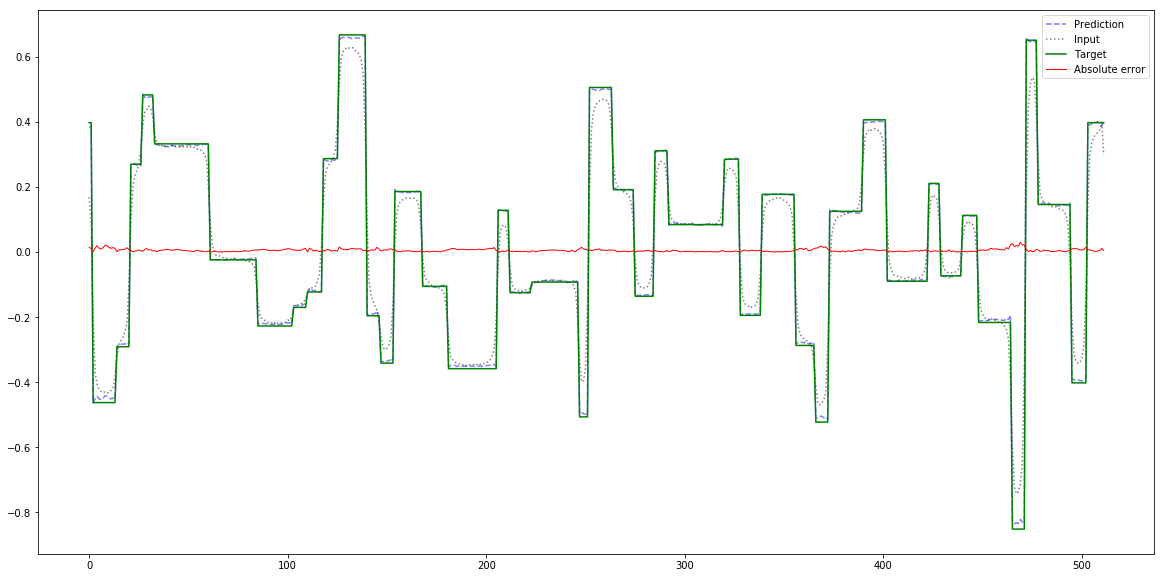

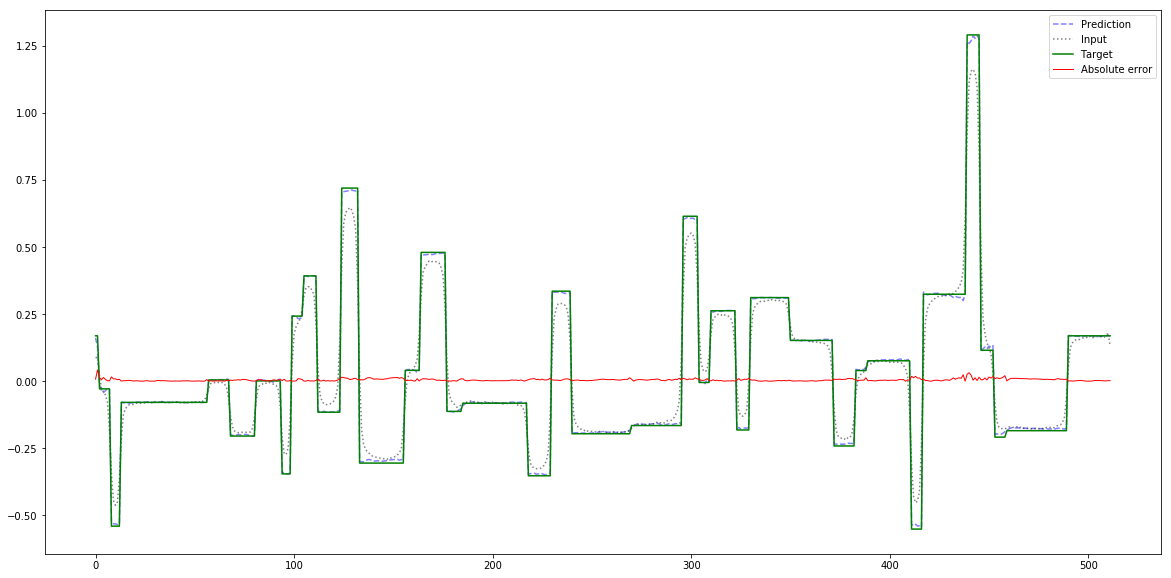

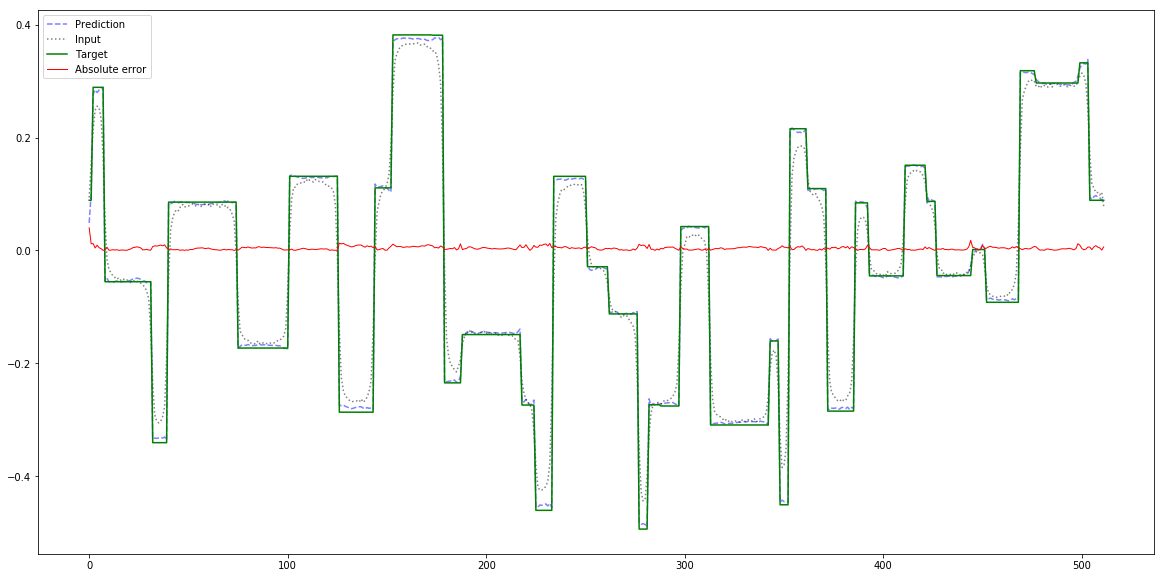

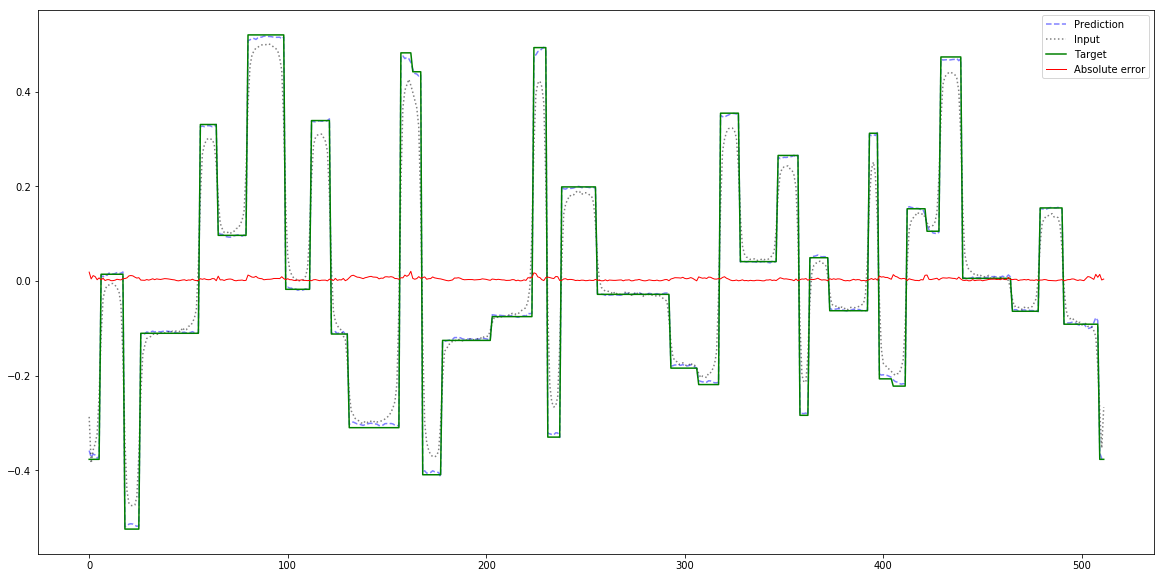

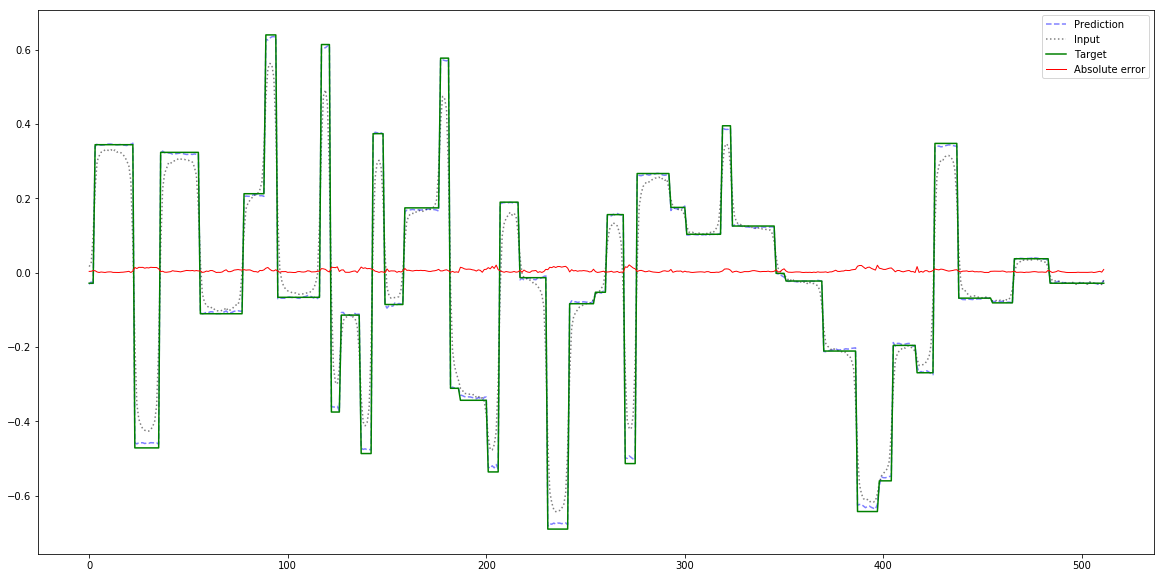

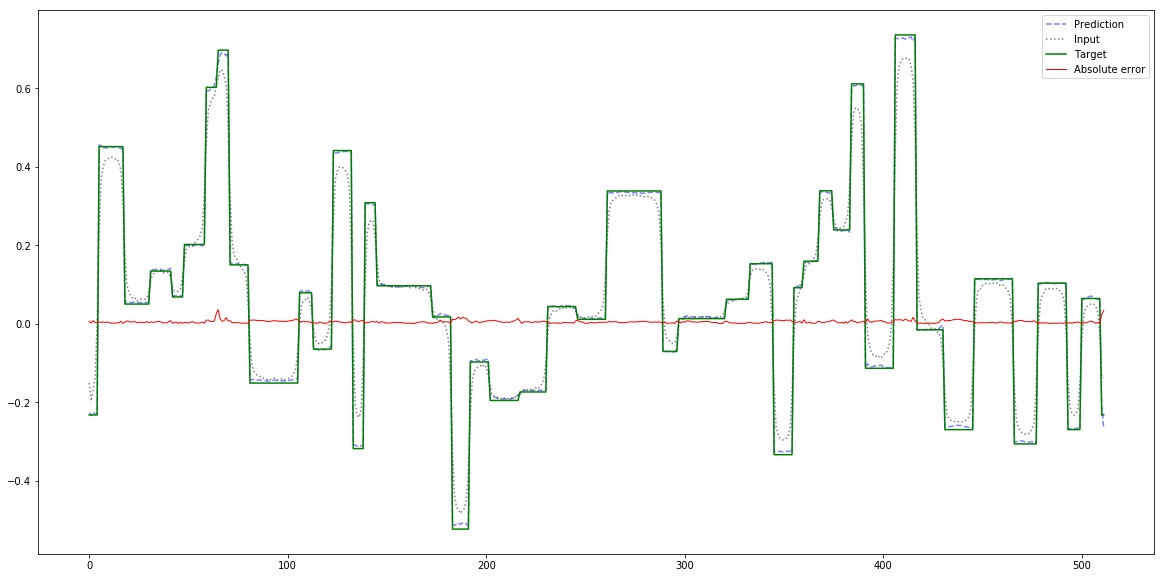

In [11]:
make_plot_det(train_matrices_path, 'train', 6)

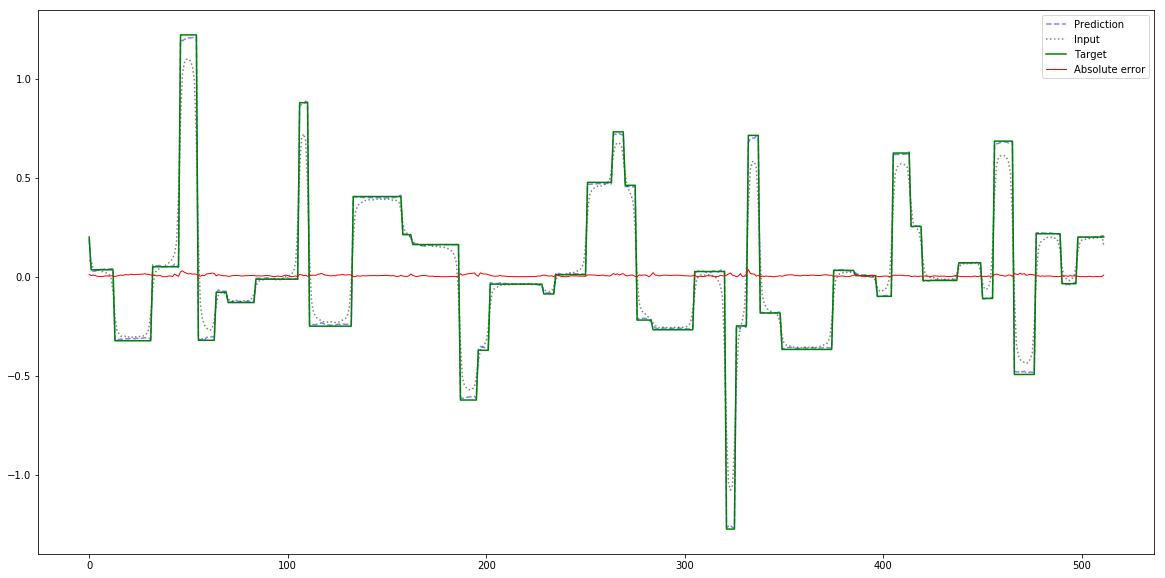

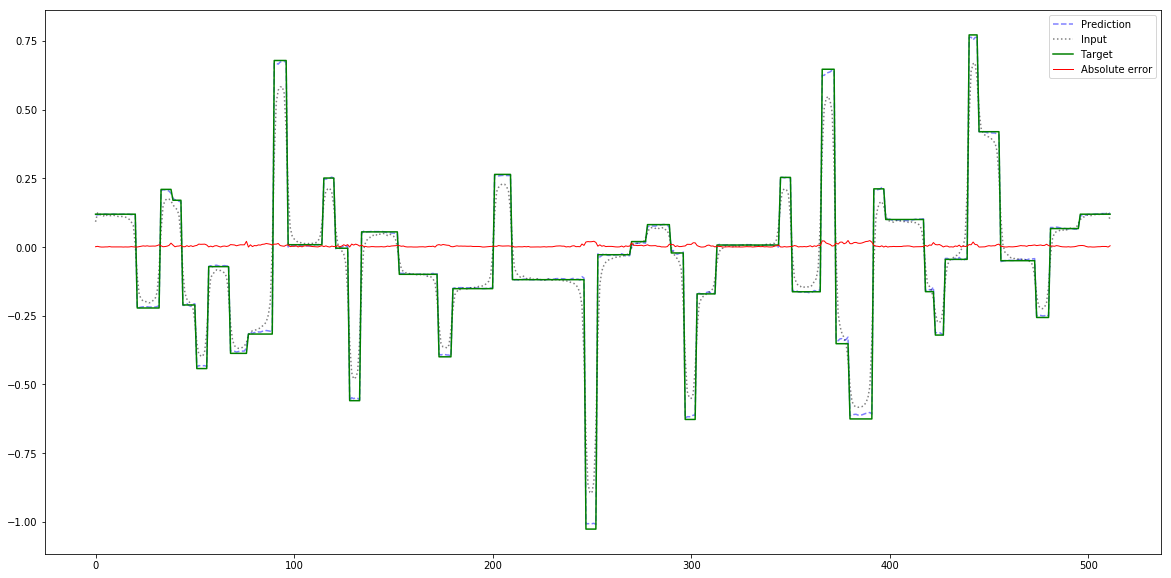

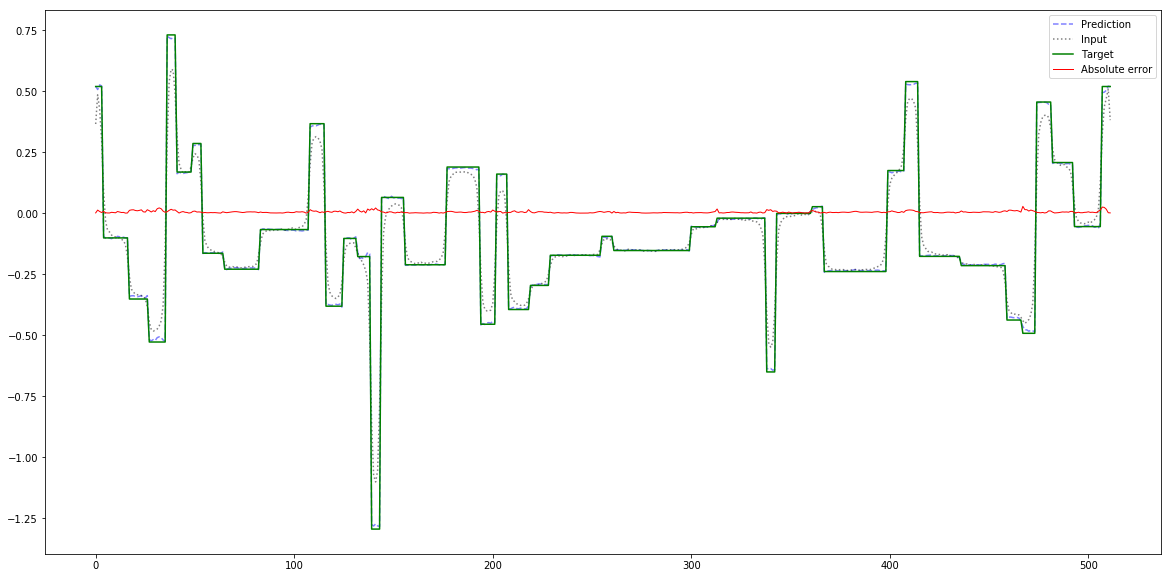

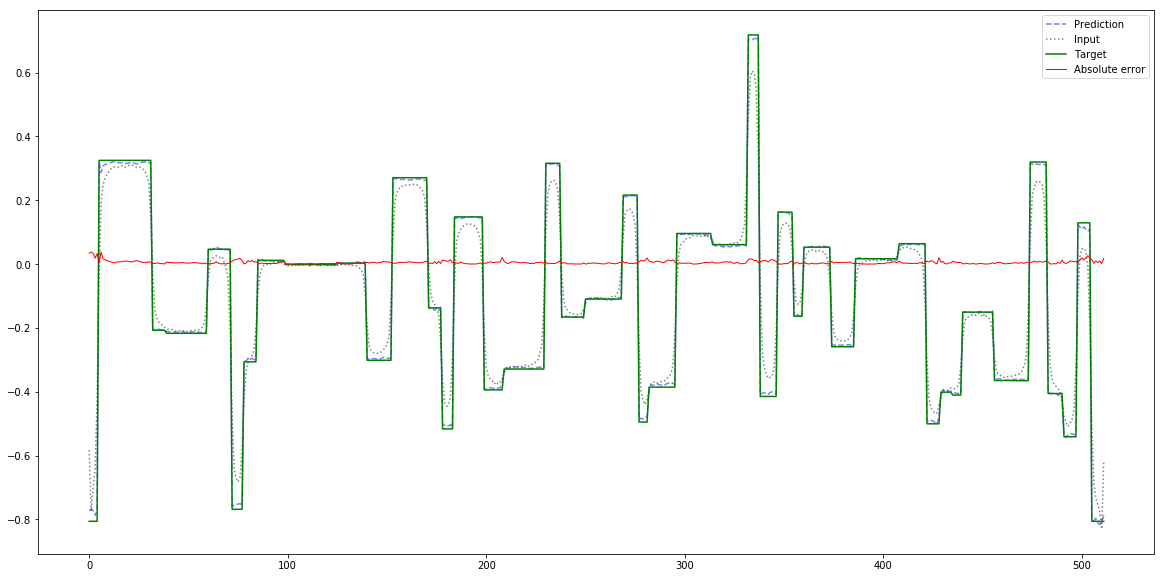

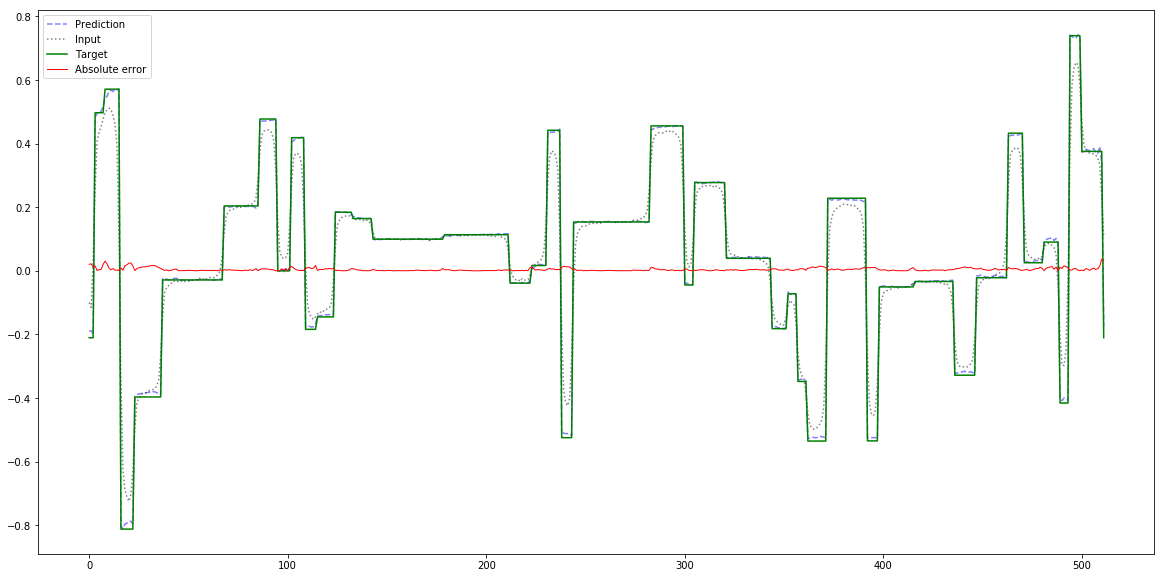

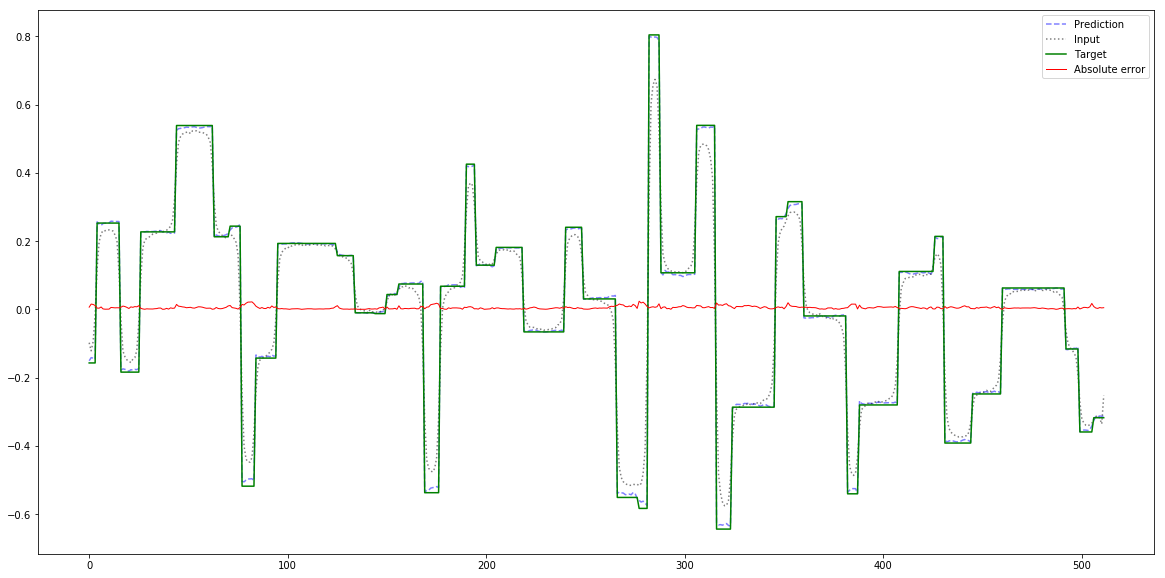

In [12]:
make_plot_det(test_matrices_path, 'test', 6)